<a href="https://colab.research.google.com/github/uakarsh/latr/blob/main/examples/textvqa/LaTr_TextVQA_Part_2_Making_the_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Downloading the requirements

!pip install -q transformers
!pip install -q sentencepiece==0.1.91
!pip install -q pytesseract
!sudo apt install -q tesseract-ocr
!pip install -q 'Pillow==7.1.2'

     |████████████████████████████████| 4.2 MB 33.2 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 26.1 MB/s 
     |████████████████████████████████| 3.1 MB 46.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr te

In [ ]:
!git clone https://github.com/uakarsh/latr.git
import sys
sys.path.append('/content/latr/src/latr/')

Cloning into 'latr'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 137 (delta 47), reused 79 (delta 20), pack-reused 0
Receiving objects: 100% (137/137), 158.96 KiB | 914.00 KiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Default Library import

import os
import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import json

## For the purpose of displaying the progress of map function
tqdm.pandas()


## Visualization libraries
from google.colab.patches import cv2_imshow
import pytesseract
from PIL import Image, ImageDraw

## Specific libraries of LaTr
import torch.nn as nn
from dataset import load_json_file, get_specific_file, resize_align_bbox, get_tokens_with_boxes, create_features
from modeling import LaTr_for_pretraining

## Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
## Setting the hyperparameters as well as primary configurations

PAD_TOKEN_BOX = [0, 0, 0, 0]
max_seq_len = 512
batch_size = 2
target_size = (500,384)
t5_model = "t5-base"

In [ ]:
## The TextVQA Dataset is present in my drive
## It can be downloaded from this link: https://drive.google.com/drive/folders/1bR03cRGnPENCiUaurKSGTSNQHUQlsDCR?usp=sharing or from official dataset 
##  and place it in the google drive, thats it!!

base_path = 'drive/MyDrive/TextVQA/'
ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_train.json')
train_json_path = os.path.join(base_path, 'TextVQA_0.5.1_train.json')


# train_images = os.scandir(os.path.join('drive/MyDrive/TextVQA', 'train_images'))
# train_images = pd.DataFrame({'images': train_images})
# train_images['images'] = train_images['images'].progress_apply(lambda x: os.path.join(os.path.join('drive/MyDrive/TextVQA', 'train_images'), x))

# ## Converting to list
# train_images = train_images['images'].tolist()

In [ ]:
train_ocr_json = json.load(open(ocr_json_path))['data']
train_json = json.load(open(train_json_path))['data']

In [ ]:
## Useful for the key-value extraction

train_json_df = pd.DataFrame(train_json)
train_ocr_json_df = pd.DataFrame(train_ocr_json)

In [ ]:
## Converting list to string

train_json_df['answers'] = train_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))

In [ ]:
## Dropping of the images which doesn't exist, might take some time

base_img_path = os.path.join('drive/MyDrive/TextVQA', 'train_images')
train_json_df['path_exists'] = train_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
print("Before shape:", train_json_df.shape[0])
train_json_df = train_json_df[train_json_df['path_exists']==True]
print("After shape:", train_json_df.shape[0])

  0%|          | 0/34602 [00:00<?, ?it/s]

Before shape: 34602
After shape: 27068


In [ ]:
train_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens', 'path_exists'
                              ], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
## Deleting the json

del train_json
del train_ocr_json

In [ ]:
## Grouping for the purpose of feature extraction
grouped_df = train_json_df.groupby('image_id')

## Getting all the unique keys of the group by object
keys = list(grouped_df.groups.keys())

In [ ]:
label2id = {}   ## Would be responsible for mapping answer to token
raw_answer = train_json_df['answers'].values.tolist()

In [ ]:
current_word_id = 1   ## Not zero, because T5 tokenizer has a pad_token_id = 0, and we would keep pad token id to be 0 for padding the answer

for ans in tqdm(raw_answer):
  for word in ans.split(" "):

    if word not in label2id:
      label2id[word] = {'id':current_word_id, 'count': 1}
      current_word_id+=1
      
    else:
      label2id[word]['count']+=1

  0%|          | 0/27068 [00:00<?, ?it/s]

In [ ]:
id2label = ["" for _ in range(current_word_id)]
for key, value in list(label2id.items()):
  id2label[value['id']] = key

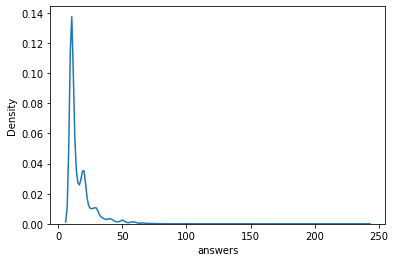

In [ ]:
## Plotting the distribution of length of answer

import seaborn as sns
sns.kdeplot(train_json_df['answers'].str.split(' ').apply(len))

In [ ]:
## Analyzing the OCR Info

sample_ocr_token = train_ocr_json_df[train_ocr_json_df['image_id']==keys[0]]

In [ ]:
sample_ocr_token

,image_id,ocr_tokens,ocr_info
8393,0000599864fd15b3,"[+*#, A, ERIEESTOMES, .#, 50, om.hk, M..*, 292...","[{'word': '+*#', 'bounding_box': {'width': 0.0..."


In [ ]:
for item in sample_ocr_token['ocr_info'].values.tolist()[0]:
  break

In [ ]:
item

{'bounding_box': {'height': 0.02601468563079834,
  'pitch': 0,
  'roll': 0,
  'rotation': 0,
  'top_left_x': 0.6012395620346069,
  'top_left_y': 0.3231566548347473,
  'width': 0.06857017427682877,
  'yaw': 0.3725101947784424},
 'word': '+*#'}

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained(t5_model)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


## Making the Dataset

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def convert_ans_to_token(answer, label2id, max_seq_length = 512 ):

  ## Simple Trick to pad a sequence to deired length
  dummy_array = torch.zeros(max_seq_length)
  actual_ans_array = []

  answer = answer.split(" ")
  for token in answer:
    actual_ans_array.append(label2id[token]['id'])
  
  actual_ans_array = torch.tensor(actual_ans_array, dtype = torch.int32)
  actual_ans_array = pad_sequence([actual_ans_array,dummy_array ], batch_first  = True)[0]

  return actual_ans_array


def convert_ques_to_token(question, tokenizer, pad_token_id = 0, max_seq_len = 512):

  question_array = []
  question = question.split(" ")
  
  for token in question:
    question_array.extend(tokenizer(token, add_special_tokens = False).input_ids)
  
  if len(question_array)< max_seq_len:
        question_array.extend([pad_token_id]* (max_seq_len-len(question_array)))

  question_array = torch.tensor(question_array, dtype = torch.int32)
  return question_array[:max_seq_len]

In [ ]:
## To be taken from here
## https://logicatcore.github.io/scratchpad/lidar/sensor-fusion/jupyter/2021/04/20/3D-Oriented-Bounding-Box.html

import math
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    
    modified from answer here: https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    """
    # angle = np.deg2rad(angle)
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)

In [ ]:
## Defining the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class TextVQA(Dataset):
  def __init__(self, base_img_path, json_df, ocr_json_df, tokenizer ,label2id, transform = None, max_seq_length = 512, target_size = (500,384)):

    self.base_img_path = base_img_path
    self.json_df = json_df
    self.ocr_json_df = ocr_json_df
    self.tokenizer = tokenizer
    self.target_size = target_size
    self.transform = transform
    self.max_seq_length = max_seq_length
    self.label2id = label2id

  def __len__(self):
    return len(self.json_df)

  def __getitem__(self, idx):

    curr_img = self.json_df.iloc[idx]['image_id']
    ocr_token = self.ocr_json_df[self.ocr_json_df['image_id']==curr_img]['ocr_info'].values.tolist()[0]

    boxes = []
    words = []

    current_group = self.json_df.iloc[idx]
    width, height = current_group['image_width'], current_group['image_height']

    ## Getting the ocr and the corresponding bounding boxes
    for entry in ocr_token:
      xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
      xmin, ymin,w, h = resize_align_bbox([xmin, ymin, w, h], 1, 1, width, height)

      x_centre = xmin + (w/2)
      y_centre = ymin + (h/2)

      # print("The angle is:", angle)
      xmin, ymin = rotate([x_centre, y_centre], [xmin, ymin], angle)

      xmax = xmin + w
      ymax = ymin + h

      ## Bounding boxes are normalized
      curr_bbox = [xmin, ymin, xmax, ymax]
      boxes.append(curr_bbox)
      words.append(entry['word'])

    img_path = os.path.join(self.base_img_path, curr_img)+'.jpg'  ## Adding .jpg at end of the image, as the grouped key does not have the extension format 

    assert os.path.exists(img_path)==True, f'Make sure that the image exists at {img_path}!!'
    ## Extracting the feature
    img, boxes, tokenized_words = create_features(image_path = img_path,
                                                  tokenizer = self.tokenizer,
                                                  target_size = self.target_size,
                                                  max_seq_length = self.max_seq_length,
                                                  use_ocr = False,
                                                  bounding_box = boxes,
                                                  words = words
                                                  )
    
    ## Converting the boxes as per the format required for model input
    boxes = torch.as_tensor(boxes, dtype=torch.int32)
    width = (boxes[:, 2] - boxes[:, 0]).view(-1, 1)
    height = (boxes[:, 3] - boxes[:, 1]).view(-1, 1)
    boxes = torch.cat([boxes, width, height], axis = -1)

    ## Tensor tokenized words
    tokenized_words = torch.as_tensor(tokenized_words, dtype=torch.int32)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)


    ## Getting the Question
    question = current_group['question']   
    question = convert_ques_to_token(question = question, tokenizer = self.tokenizer)

    ## Getting the Answer
    answer = current_group['answers']
    answer = convert_ans_to_token(answer, self.label2id)

    return {'img':img, 'boxes': boxes, 'tokenized_words': tokenized_words, 'question': question, 'answer': answer}

In [ ]:
train_ds = TextVQA(base_img_path = base_img_path,
                   json_df = train_json_df,
                   ocr_json_df = train_ocr_json_df,
                   tokenizer = tokenizer,
                   label2id = label2id,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   target_size = target_size
                   )

In [ ]:
idx = 3

In [ ]:
encoding = train_ds[idx]  ## Might take time as per the processing

In [ ]:
for key in list(encoding.keys()):
  print_statement = '{0: <30}'.format(str(key) + " has a shape:")
  print(print_statement, encoding[key].shape)

img has a shape:               torch.Size([3, 384, 500])
boxes has a shape:             torch.Size([512, 6])
tokenized_words has a shape:   torch.Size([512])
question has a shape:          torch.Size([512])
answer has a shape:            torch.Size([512])


In [ ]:
## Sample Img, Sample box, sample words

s_img = encoding['img']
s_boxes = encoding['boxes']
s_words = encoding['tokenized_words']

## Plotting the Image and the bounding boxes

In [ ]:
actual_img = transforms.ToPILImage()(s_img).convert("RGB")
actual_boxes = s_boxes[:, :4].numpy().tolist()  ## (xmin, ymin, xmax, ymax)

In [ ]:
from PIL import Image, ImageDraw

# create rectangle image
draw_on_img = ImageDraw.Draw(actual_img)  

for box in actual_boxes:
  draw_on_img.rectangle(box, outline ="red")


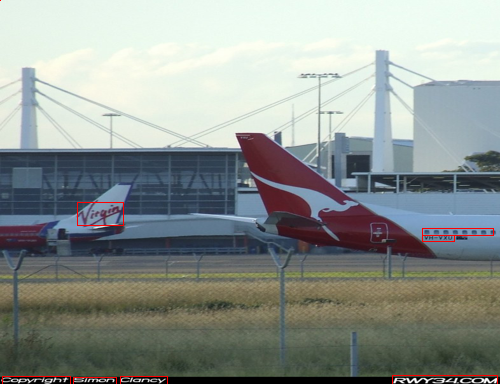

In [ ]:
actual_img

In [ ]:
## Seems like, we can now make the model as we have now got the features as well as the label, and plotted the features :)
## Onto, the next notebook for modeling the TextVQA and LaTr .........

## Rough work for Rotation of Bounding box

In [ ]:
# idx = 1
# new_img_id = train_json_df.iloc[idx]['image_id']
# ocr_info = train_ocr_json_df[train_ocr_json_df['image_id']==new_img_id]['ocr_info'].values.tolist()[0]
# entry = ocr_info[0]
# img_path = os.path.join(os.path.join('drive/MyDrive/TextVQA', 'train_images'), new_img_id)+'.jpg'
# os.path.exists(img_path)